In [1]:
import os

# set dir by hardcode to run in crontab
os.chdir("/home/jacob/Project/LendingClub/")

import Data_Helper as DH
import lendingclub
import prediction
import investment
import backtester
import numpy as np
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None  # default='warn'
%load_ext autoreload
%autoreload 2

# 1. Initiate Config, Data, LendingClub Objects

In [2]:
# initialize config object
config = lendingclub.ConfigData("config_data_dummy.ini")

# initialize lendingclup api object
lc = lendingclub.LendingClub(config)

# initialize data transformer
transformer = DH.Transformer_full()

# initialize DataHelper
periodStart = ("Q1", "2016")
periodEnd = ("Q1", "2018")
DataHelper = DH.DataHelper(periodStart, periodEnd, transformer, lc)

In [3]:
# set training data
DataHelper.set_training_dataset()

In [4]:
# set test data
DataHelper.set_test_dataset(["LoanStats_2018Q2.csv", "LoanStats_2018Q3.csv"])

# 2. Initiate the fitted models

## Initiate the Logistic model from the saved file

In [5]:
filename = "logistic_regression_20201221.sav"

In [6]:
# instantiate from beginning
lr = prediction.ModelLogistic(filename)

# update from the saved model
lr.set_model_from_file()

# check model description
lr.model_description

Model is loaded from logistic_regression_20201221.sav


'Logistic Regression Object, time: 12/21/2020, C: 1000, penalty: l1, solver: saga, max_iter: 500, tol: 0.0005'

## Initiate the Random Forest from the saved file

In [ ]:
#filename = "rf_classification_20190502.sav"

In [ ]:
# instantiate from beginning
# rf = prediction.ModelRandomForest(filename)

# update from the saved model
# rf.set_model_from_file()

# check model description
# rf.model_description

## Initiate the XGB model from the saved file

In [9]:
filename = "xgb_classification_20201223_Prod.sav"

In [10]:
# instantiate from beginning
xgb = prediction.ModelXGBClassfication(filename)

# update from the saved model
xgb.set_model_from_file()

# check model description
xgb.model_description

Model is loaded from xgb_classification_20201223_Prod.sav


'XGBoost Classification Object, time: 12/23/2020, eta: 0.01, num_rounds: 3950, max_depth: 6, subsample: 0.7'

# 3. Run model on test dataset

In [59]:
def add_score_and_bucket(model, df, n_bucket):
    
    # get prediction
    pred = model.predict_model(df)

    # get length
    n = len(pred)

    # combine prediction prob to dataset
    df = model.clean_data(df, prediction=False, index=False)
    df["score"] = pred
    df = df.sort_values("score")
    
    # add bucket
    inc = n//n_bucket
    bar = [i*inc for i in range(1,n_bucket+1)]
    bar[-1] = bar[-1] + n%n_bucket
    
    index = np.array(list(range(0,n)))
    f = np.vectorize(lambda x: len(bar) - sum([x<=i for i in bar])+1)
    buckets = f(index)
    
    df["bucket"] = buckets
    cut = df[["bucket","score"]].groupby(["bucket"]).agg("max")
    
    return n, df, cut

In [60]:
n_bucket = 50

## Logistic Model

In [61]:
# get training/test for this model
training, test = lr.get_data_for_model(DataHelper.training, DataHelper.test)

In [62]:
# get score
score = lr.test_model(test)
print("test score:",score)

test score: {'score': 0.8058677065356291, 'AUC': 0.7062003909889552}


In [63]:
# add score and bucket
_, df_lr_train, cut_lr_train = add_score_and_bucket(lr, DataHelper.training, n_bucket)

In [64]:
# add score and bucket
_, df_lr_test, cut_lr_test = add_score_and_bucket(lr, DataHelper.test, n_bucket)

## GBM Model

In [65]:
# get training/test for this model
training, test = xgb.get_data_for_model(DataHelper.training, DataHelper.test)

In [66]:
# get score
score = xgb.test_model(test)
print("test score:",score)

test score: {'score': 0.7898390659514042, 'AUC': 0.7226549073435964}


In [67]:
# add score and bucket
_, df_xgb_train, cut_xgb_train = add_score_and_bucket(xgb, DataHelper.training, n_bucket)

In [68]:
# add score and bucket
_, df_xgb_test, cut_xgb_test = add_score_and_bucket(xgb, DataHelper.test, n_bucket)

# 4. Default Ratio by Score Bucket

The result of xgb clearly outperforms other models in the good buckets. Please note that 1~2% difference in AUC can leads to very differnt return in the end. This is why we need to dedicate time to increase the prediction power of underlying machine learning model.

In [69]:
def get_def_ratio_by_bucket(**kwargs):
    
    results = {}
    for key, df in kwargs.items():
        cnt = df.loc[:,["bad_loan", "bucket"]].groupby("bucket").agg("sum")
        tot = df.loc[:,["bad_loan", "bucket"]].groupby("bucket").agg("count")
        rat = cnt/tot
        results[key] = rat["bad_loan"]
    
    results = pd.DataFrame(results)
    return results

This is for training set

In [70]:
# get default rates by bucket for each model
default_results = get_def_ratio_by_bucket(lr = df_lr_train, xgb = df_xgb_train)

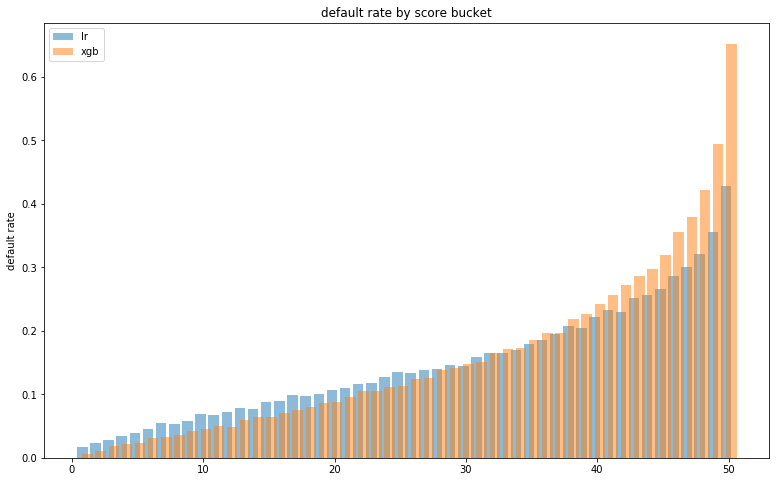

In [71]:
# show default rates by bucket for each model
plt.figure(figsize=(13,8))
plt.bar(default_results.index.values-0.2, default_results["lr"], align='center', alpha=0.5)
plt.bar(default_results.index.values+0.2, default_results["xgb"], align='center', alpha=0.5)
plt.legend(["lr","xgb"])
plt.ylabel('default rate')
plt.title('default rate by score bucket')
plt.show()

This is for test set

In [72]:
# get default rates by bucket for each model
default_results = get_def_ratio_by_bucket(lr = df_lr_test, xgb = df_xgb_test)

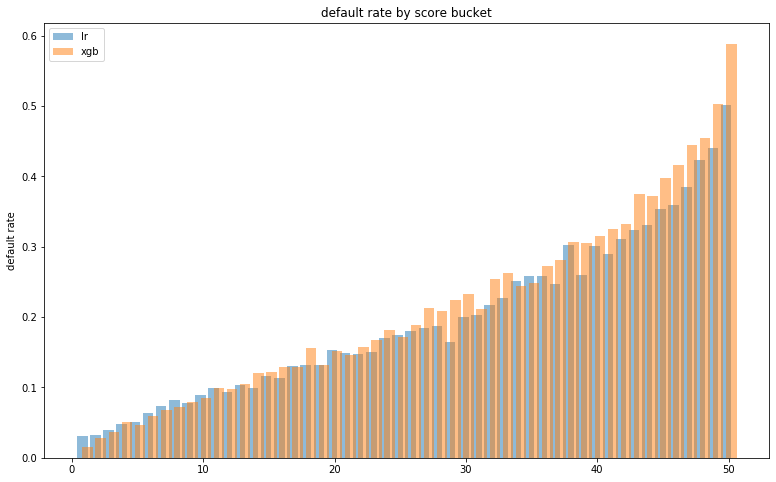

In [73]:
# show default rates by bucket for each model
plt.figure(figsize=(13,8))
plt.bar(default_results.index.values-0.2, default_results["lr"], align='center', alpha=0.5)
plt.bar(default_results.index.values+0.2, default_results["xgb"], align='center', alpha=0.5)
plt.legend(["lr","xgb"])
plt.ylabel('default rate')
plt.title('default rate by score bucket')
plt.show()

In [75]:
default_results.head()

,lr,xgb
bucket,,
1,0.031600,0.015771
2,0.032279,0.027613
3,0.038867,0.036982
4,0.048748,0.050296
5,0.051383,0.046844


# 5. Comparison of Default Rate and Interest Rate

Based on the default rate and interest rate comparison, only the first few buckets are expected to have positive return. To check the rough expectation of our investments, we compared the default rate and interest rate. The interest rate here is the total 3-year interest rate with equal monthly installment of the loans. The first bucket of xdg model would have highestt payoff as 6.2%. Of course, we need to consider prepayment timing, monthly installmet, etc., to properly calculate the expected payoff, so this is rough estimation.

However, the observation clearly states that we need to stick to the first few buckets to be profitable.

In [76]:
def get_int_rate_by_bucket(**kwargs):
    
    results = {}
    origin = np.array([1-x/36 for x in range(0,37)])
    
    for key, df in kwargs.items():
        # add total interest rate
        month_rate = df.int_rate/12
        df["tot_int_rate"] = np.array([sum(origin*x) for x in month_rate])
        # get average by bucket
        rate = df.loc[:,["tot_int_rate", "bucket"]].groupby("bucket").agg("mean")
        results[key] = rate["tot_int_rate"]
    
    results = pd.DataFrame(results)
    return results

In [77]:
# get average interest rates by bucket for each model
int_results = get_int_rate_by_bucket(lr = df_lr_test, xgb = df_xgb_test)

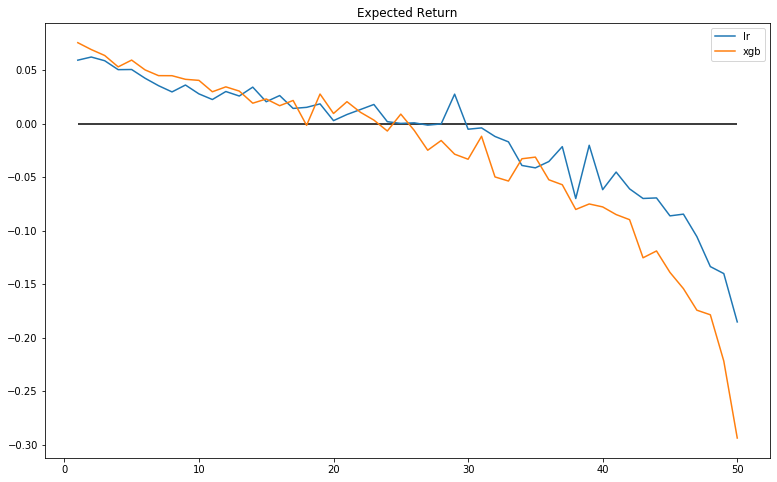

In [78]:
plt.figure(figsize=(13,8))
for name in int_results.columns.values:
    plt.plot(default_results.index.values, int_results[name] - default_results[name])
plt.hlines(0,xmin=min(default_results.index.values),xmax=max(default_results.index.values))
plt.legend(int_results.columns.values)
plt.title("Expected Return")
plt.show()

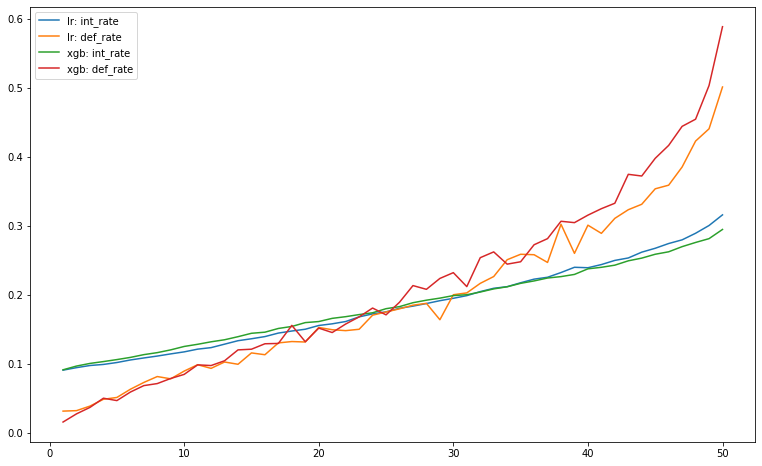

In [80]:
plt.figure(figsize=(13,8))
legends = []
for name in int_results.columns.values:
    plt.plot(default_results.index.values, int_results[name])
    plt.plot(default_results.index.values, default_results[name])
    legends.append(name + ": int_rate")
    legends.append(name + ": def_rate")

plt.legend(legends)
plt.show()

In [81]:
for name in default_results.columns.values:
    default_results[name + "_int"] = int_results[name]
    default_results[name + "_diff"] =  default_results[name + "_int"] - default_results[name]

default_results.head(7)

,lr,xgb,lr_int,lr_diff,xgb_int,xgb_diff
bucket,,,,,,
1,0.031600,0.015771,0.090955,0.059356,0.091469,0.075698
2,0.032279,0.027613,0.094581,0.062302,0.096888,0.069275
3,0.038867,0.036982,0.097693,0.058826,0.100710,0.063727
4,0.048748,0.050296,0.099240,0.050491,0.103384,0.053088
5,0.051383,0.046844,0.102014,0.050631,0.106276,0.059432
6,0.063241,0.059172,0.105696,0.042455,0.109424,0.050253
7,0.073123,0.068540,0.108624,0.035502,0.113435,0.044895


Please note the number of loans in the first bucket issued during two quarters are sufficient to diversify the investment, since we can invest more than $4,7000.

In [82]:
print("we can invest more than {} amount in first bucket during two quarters.".
      format(df_xgb_test.shape[0]//n_bucket*25))

we can invest more than 50700 amount in first bucket during two quarters.


# 6. Heatmap - distribution of Grade by score

First few buckets only include A-grades and B1 grade loans. Our model further differentiate loans among A-grade groups.

In [83]:
grades = list(df_xgb_test["sub_grade"].unique())
grades.sort()
buckets = list(range(1,n_bucket+1))

In [84]:
# get counts by grade and bucket
heatmap = np.zeros([len(grades),n_bucket])
groups = df_xgb_test.loc[:,["sub_grade", "bucket","bad_loan"]].groupby(["bucket","sub_grade"])

for group in groups:
    b = buckets.index(group[0][0])
    g = grades.index(group[0][1])
    count = len(group[1])    
    heatmap[g,b] = count  

In [85]:
# get ratio
heatmap = heatmap.transpose()
heatmap = np.array([x/sum(x) for x in heatmap])
heatmap = heatmap.transpose()

In [86]:
# change it to df
heatmap_df = pd.DataFrame(heatmap,index=grades,columns=buckets)

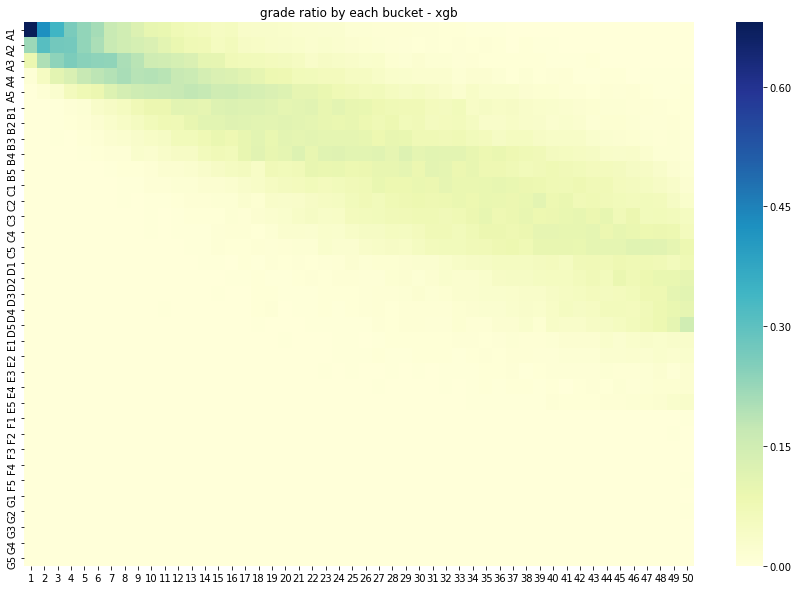

In [87]:
plt.figure(figsize=(15,10))
ax=sns.heatmap(heatmap_df, cmap="YlGnBu")
ax.set_title("grade ratio by each bucket - xgb")
plt.show()